# **1. Perkenalan Dataset**


**Sumber Dataset**:  
   Dataset dapat diperoleh dari sumber yang disediakan oleh Dicoding, yaitu data penjualan minuman (*Beverage Sales*).

# **2. Import Library**

Pada tahap ini, Anda perlu mengimpor beberapa pustaka (library) Python yang dibutuhkan untuk analisis data dan pembangunan model machine learning.

In [2]:
import pandas as pd 
import matplotlib.pyplot as plt 
from yellowbrick.cluster import KElbowVisualizer 
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from IPython.display import display, HTML
from scipy.stats import chi2_contingency

# **3. Memuat Dataset**

In [3]:
initial_df = pd.read_csv('Dataset_clustering.csv')

In [4]:
print("Dataframe shape:", initial_df.shape)

Dataframe shape: (8999910, 11)


In [5]:
initial_df.sample(10, random_state=0)

,Order_ID,Customer_ID,Customer_Type,Product,Category,Unit_Price,Quantity,Discount,Total_Price,Region,Order_Date
1097018,ORD365385,CUS9226,B2C,Granini Apple,Juices,1.69,15,0.00,25.35,Hamburg,2023-03-11
367205,ORD122170,CUS8650,B2C,Krombacher,Alcoholic Beverages,1.63,5,0.00,8.15,Berlin,2023-06-15
8284638,ORD2761511,CUS3082,B2B,Gerolsteiner,Water,1.13,78,0.10,79.33,Nordrhein-Westfalen,2022-11-19
3385218,ORD1127835,CUS4185,B2B,Tomato Juice,Juices,2.07,31,0.05,60.96,Rheinland-Pfalz,2021-12-24
3010030,ORD1002653,CUS3410,B2B,Red Bull,Soft Drinks,2.61,78,0.10,183.22,Hamburg,2022-05-22
3702508,ORD1233846,CUS219,B2C,Volvic Touch,Water,1.38,15,0.00,20.70,Berlin,2021-12-23
973859,ORD324358,CUS6474,B2C,Kölsch,Alcoholic Beverages,0.96,6,0.00,5.76,Hamburg,2022-11-04
5872176,ORD1957900,CUS4685,B2B,Erdinger Weißbier,Alcoholic Beverages,2.76,35,0.15,82.11,Berlin,2022-02-01
8209183,ORD2736309,CUS2517,B2C,Hohes C Orange,Juices,1.80,9,0.00,16.20,Hessen,2022-04-21
4577561,ORD1525770,CUS9184,B2C,Volvic Touch,Water,1.46,9,0.00,13.14,Sachsen,2023-04-25


# **4. Exploratory Data Analysis (EDA)**
Tujuan dari EDA adalah untuk memperoleh wawasan awal yang mendalam mengenai data dan menentukan langkah selanjutnya dalam analisis atau pemodelan.

### **1) Struktur Data**

In [6]:
def create_eda_table(dataframe):
    """
    Membuat tabel EDA untuk sebuah DataFrame.

    Args:
        dataframe (pd.DataFrame): DataFrame yang akan dianalisis.

    Returns:
        pd.DataFrame: DataFrame berisi EDA untuk kolom-kolom pada dataframe input.
    """
    # Inisialisasi list untuk menyimpan data tiap kolom
    eda_table = []

    # Iterasi setiap kolom dalam DataFrame
    for col in dataframe.columns:
        data_type = dataframe[col].dtype
        missing_value = dataframe[col].isnull().sum()
        nunique = dataframe[col].nunique()
        sample_value = dataframe[col].dropna().iloc[0] if not dataframe[col].dropna().empty else None

        # Menambahkan data ke dalam list
        eda_table.append({
            "Column": col,
            "Data Type": data_type,
            "Missing Values": missing_value,
            "Unique Values": nunique,
            "Sample Value": sample_value,
        })

    # Mengonversi list ke DataFrame untuk tabel EDA
    eda_df = pd.DataFrame(eda_table)
    return eda_df

def render_eda_table_as_html(eda_df):
    """
    Render tabel EDA sebagai HTML tanpa pemotongan kolom.

    Args:
        eda_df (pd.DataFrame): DataFrame hasil tabel EDA.

    Returns:
        str: HTML string dari tabel EDA.
    """
    # Set opsi tampilan untuk memastikan semua kolom muncul
    with pd.option_context('display.max_colwidth', None, 'display.max_columns', None):
        return eda_df.to_html(index=False, escape=False)

In [7]:
# EDA Table
eda_table = render_eda_table_as_html(create_eda_table(initial_df))
display(HTML(eda_table))

Column,Data Type,Missing Values,Unique Values,Sample Value
Order_ID,object,0,3000000,ORD1
Customer_ID,object,0,10000,CUS1496
Customer_Type,object,0,2,B2B
Product,object,0,47,Vio Wasser
Category,object,0,4,Water
Unit_Price,float64,0,12778,1.66
Quantity,int64,0,100,53
Discount,float64,0,4,0.1
Total_Price,float64,0,203842,79.18
Region,object,0,16,Baden-Württemberg


**Insights:**
- Dataset tidak memiliki missing value

**Notes:** 
- Order date perlu diubah tipe data nya

#### **Statistik Data Numerikal**

In [8]:
# Menampilkan statistik deskriptif dari dataset untuk kolom numerik
initial_df.describe()

,Unit_Price,Quantity,Discount,Total_Price
count,8.999910e+06,8.999910e+06,8.999910e+06,8.999910e+06
mean,5.818037e+00,2.313813e+01,2.972879e-02,1.307437e+02
std,1.470050e+01,2.689321e+01,4.479841e-02,5.096947e+02
min,3.200000e-01,1.000000e+00,0.000000e+00,3.000000e-01
25%,1.050000e+00,6.000000e+00,0.000000e+00,8.400000e+00
50%,1.750000e+00,1.100000e+01,0.000000e+00,2.114000e+01
75%,3.210000e+00,3.000000e+01,5.000000e-02,6.949000e+01
max,1.695300e+02,1.000000e+02,1.500000e-01,1.429530e+04


**Insights**:
- sebagian besar transaksi tidak mendapatkan diskon atau diskonnya kecil.
- Distribusi total price sangat skewed positif menunjukkan adanya outlier yang signifikan (harga premium).

### **2) Distribusi Dataset**

#### **Numerikal**

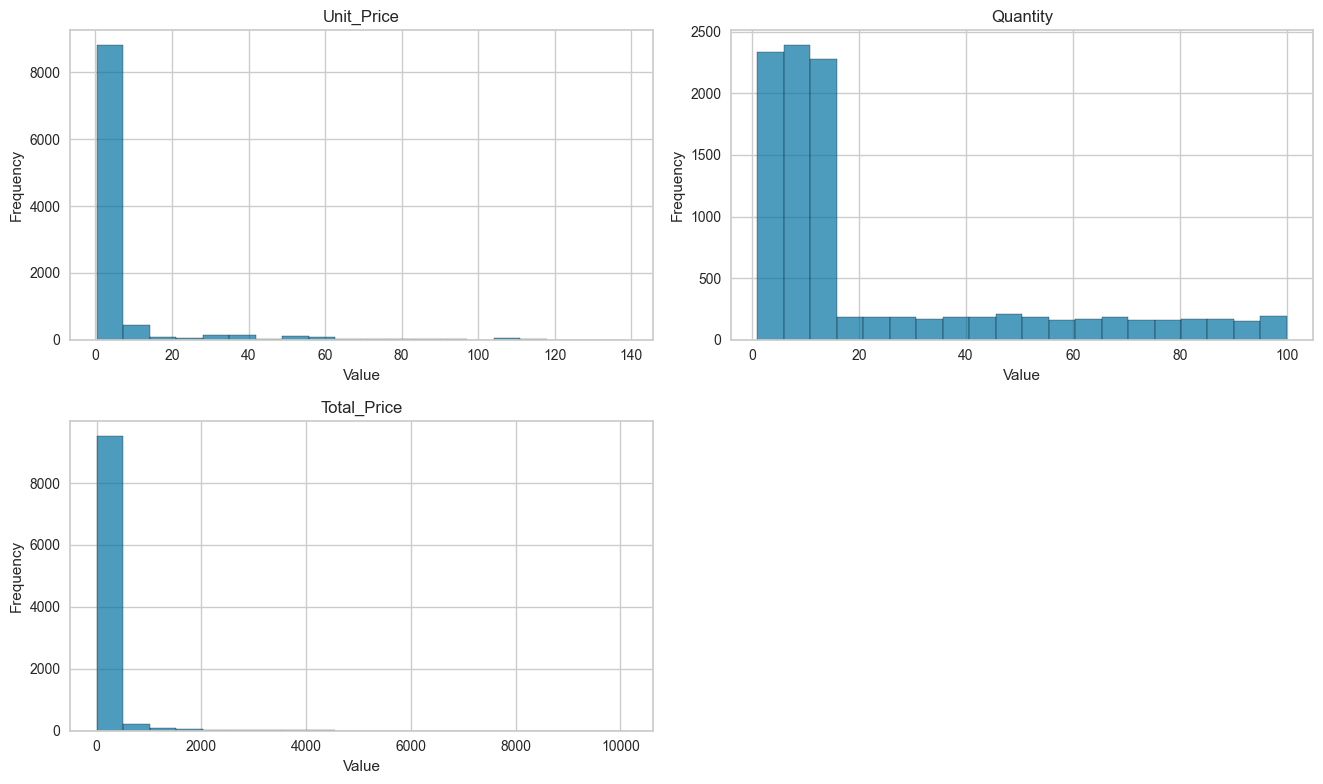

In [9]:
# Menentukan jumlah kolom numerik
numeric_cols = ['Unit_Price', 'Quantity', 'Discount', 'Total_Price']

# Sampling data jika dataset terlalu besar (misalnya ambil 100,000 sampel acak)
sample_size = min(10000, len(initial_df))  # Sesuaikan ukuran sampel
df_sample = initial_df.sample(sample_size, random_state=42)

# Menentukan jumlah baris dan kolom untuk grid subplot
n_cols = 3  # Jumlah kolom per baris
n_rows = -(-len(numeric_cols) // n_cols)  # Ceiling division

# Membuat subplot
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 4))
axes = axes.flatten()

# Loop untuk plot histogram
for i, col in enumerate(numeric_cols):
    unique_values = initial_df[col].nunique()
    
    # Hanya plot histogram jika kolom memiliki variasi yang cukup
    if unique_values > 10:  
        bins = min(20, unique_values)  # Maksimal 20 bins untuk performa optimal
        axes[i].hist(df_sample[col], bins=bins, edgecolor='black', alpha=0.7)
        axes[i].set_title(col)
        axes[i].set_xlabel('Value')
        axes[i].set_ylabel('Frequency')
    else:
        axes[i].remove()  # Hapus subplot kosong jika tidak digunakan

# Hapus subplot yang tidak terpakai
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Menyesuaikan layout
plt.tight_layout()
plt.show()


**Insights:**
- Unit_Price: Sebagian besar harga berada di rentang kecil (0-5), tetapi ada outlier hingga 150+.
- Quantity: Ada pola umum di mana sebagian besar transaksi membeli dalam jumlah kecil.
- Total_Price: Sebagian besar transaksi memiliki total pembayaran yang rendah.

**Notes:**
- Unit_Price: Perlu normalisasi atau transformasi log untuk mengurangi skewness jika digunakan dalam clustering. 
- Total_Price: Mirip dengan Unit_Price karena total harga dipengaruhi oleh harga per unit dan jumlah pembelian.

**Outlier**

c:\Users\Jihan Aurelia\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
c:\Users\Jihan Aurelia\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
c:\Users\Jihan Aurelia\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
c:\Users\Jihan Aurelia\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be 

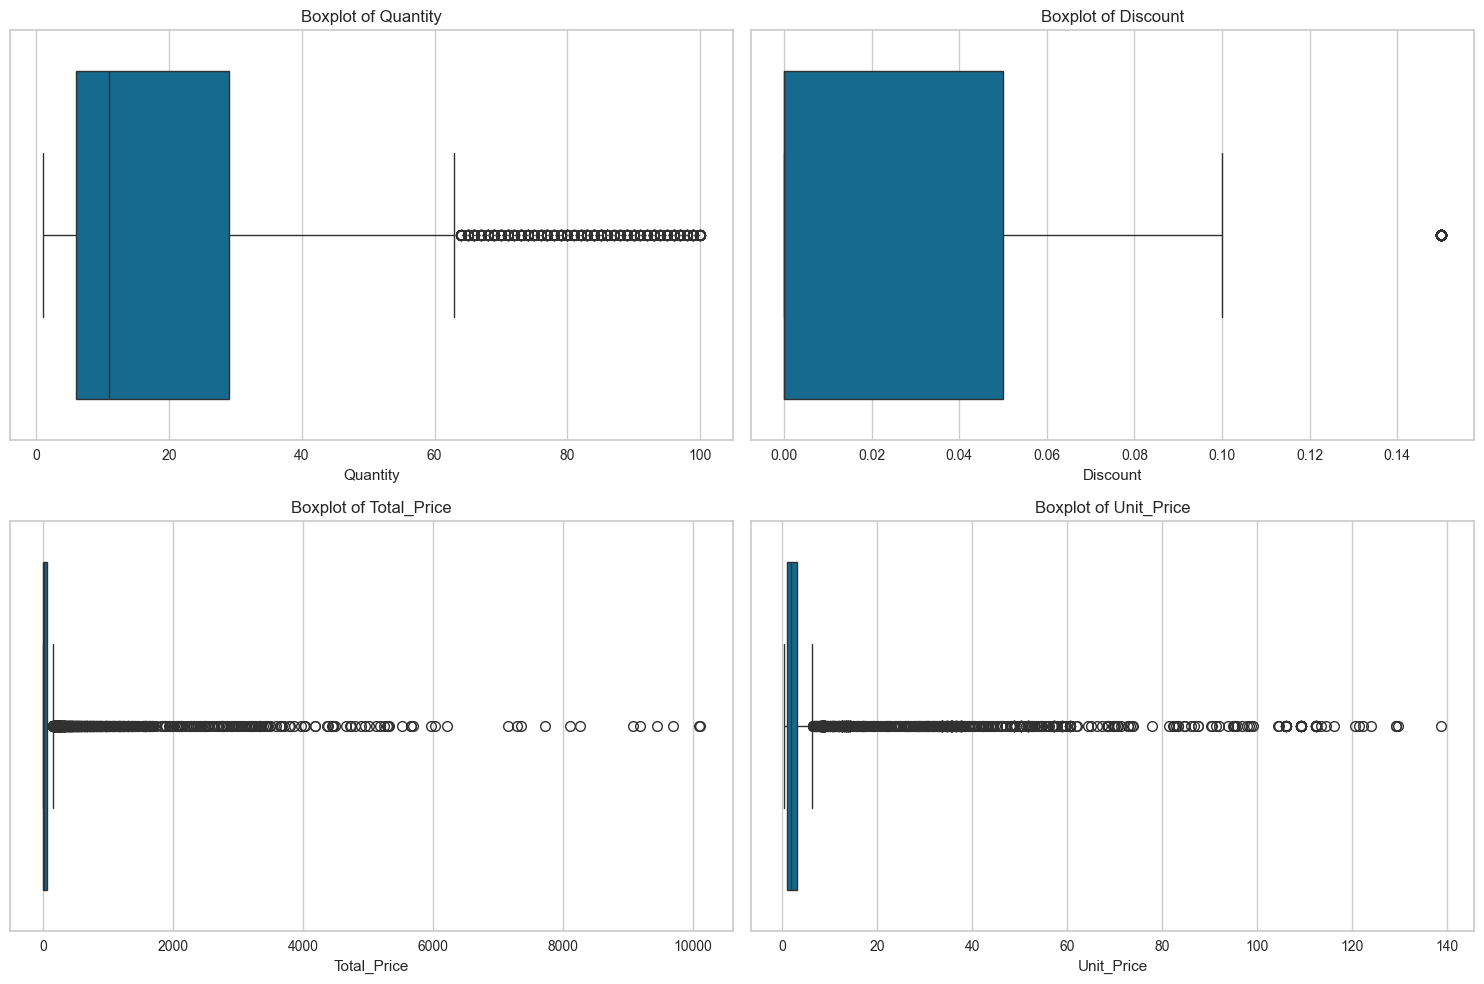

{'Quantity': 1264, 'Discount': 431, 'Total_Price': 1293, 'Unit_Price': 1208}

In [10]:
# Fungsi untuk mendeteksi outlier dengan IQR
def detect_outliers_iqr(df_sampled, column):
    Q1 = df_sampled[column].quantile(0.25)
    Q3 = df_sampled[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df_sampled[(df_sampled[column] < lower_bound) | (df_sampled[column] > upper_bound)]
    return outliers

# Kolom numerik yang ingin diperiksa
numerical_columns = ['Quantity', 'Discount', 'Total_Price', 'Unit_Price']

# Visualisasi Boxplot untuk masing-masing fitur
plt.figure(figsize=(15, 10))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x=df_sample[column])
    plt.title(f'Boxplot of {column}')

plt.tight_layout()
plt.show()

# Deteksi outlier menggunakan IQR untuk setiap fitur numerik
outlier_results = {}
for column in numerical_columns:
    outliers = detect_outliers_iqr(df_sample, column)
    outlier_results[column] = outliers.shape[0]  # Jumlah outliers

# Menampilkan hasil deteksi outlier
outlier_results

**Insights:**
- Terdapat sejulah outlier pada data numerikal

#### **Kategorikal**

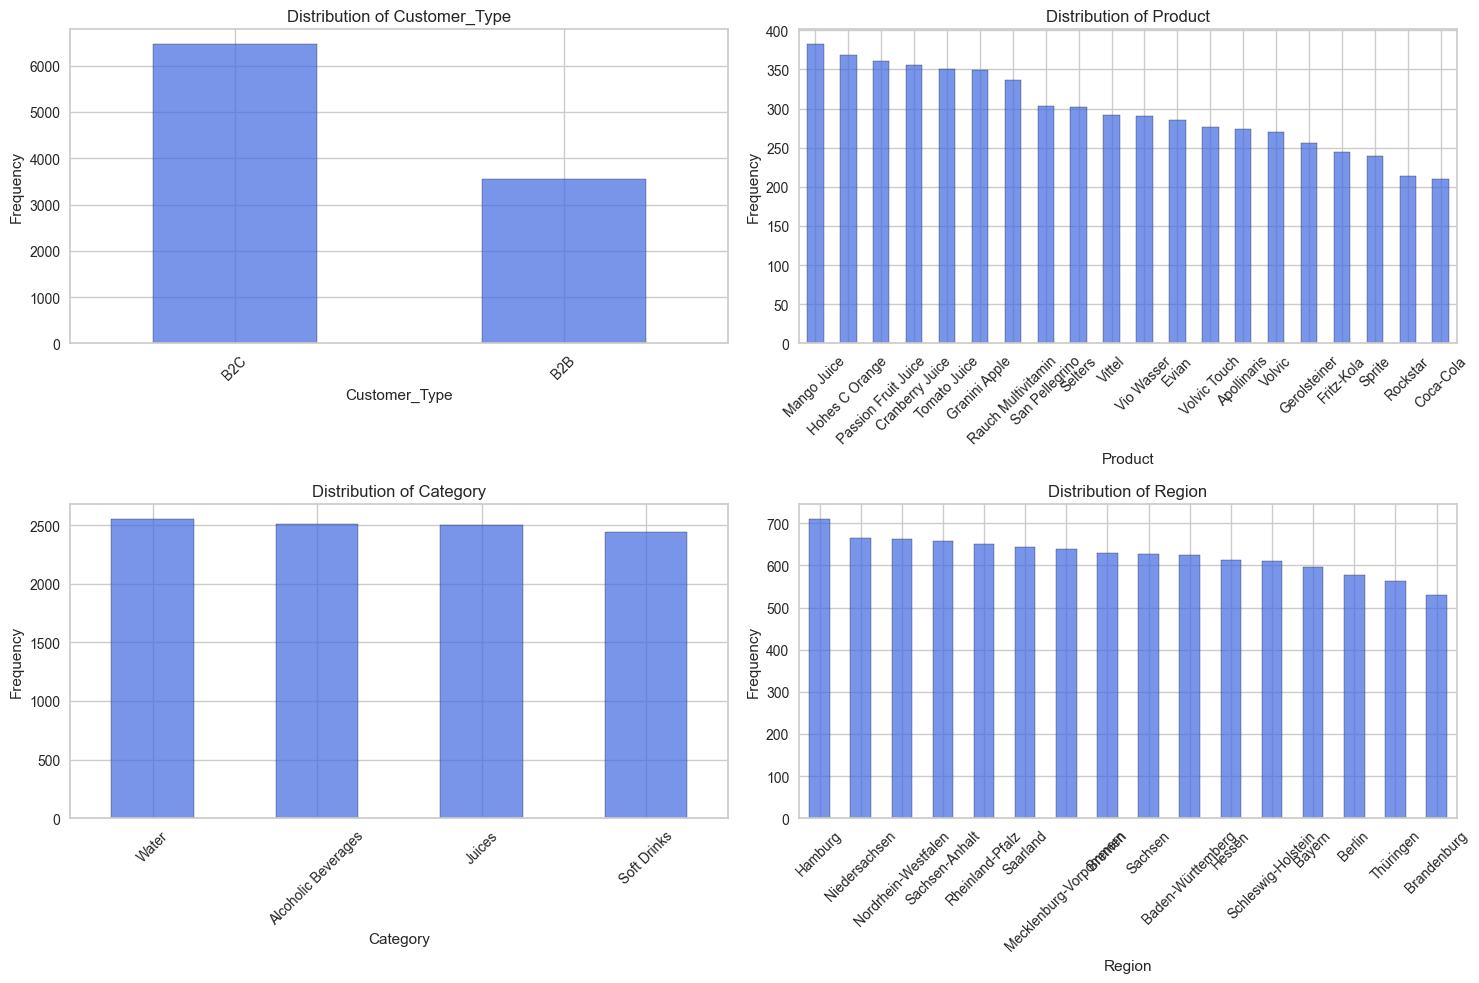

In [11]:
# Menentukan kolom kategorikal yang ingin divisualisasikan
categorical_cols = ['Customer_Type', 'Product', 'Category', 'Region']

# Menentukan jumlah baris dan kolom dalam grid subplot
n_cols = 2  # Maksimal 2 kolom agar tidak terlalu rapat
n_rows = -(-len(categorical_cols) // n_cols)  # Ceiling division

# Membuat subplot
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))
axes = axes.flatten()

# Loop untuk setiap kolom kategorikal
for i, col in enumerate(categorical_cols):
    value_counts = df_sample[col].value_counts().head(20)  # Ambil 20 kategori terbanyak jika terlalu banyak
    value_counts.plot(kind='bar', ax=axes[i], color='royalblue', edgecolor='black', alpha=0.7)

    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')
    axes[i].tick_params(axis='x', rotation=45)  # Rotasi label agar mudah dibaca

# Menghapus subplot kosong jika jumlah kategori lebih sedikit dari grid yang dibuat
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Menyesuaikan layout agar lebih rapi
plt.tight_layout()
plt.show()


**Insights:**
- Customer_Type: kurang seimbang
- Product: Sebaran produk cukup merata dengan beberapa kelompok produk dengan pembelian tinggi, sedang, dan rendah
- Category: memiliki jumlah transaksi yang hampir sama
- Region: cukup merata di berbagai region

### **3) Korelasi**

#### **Numerikal**

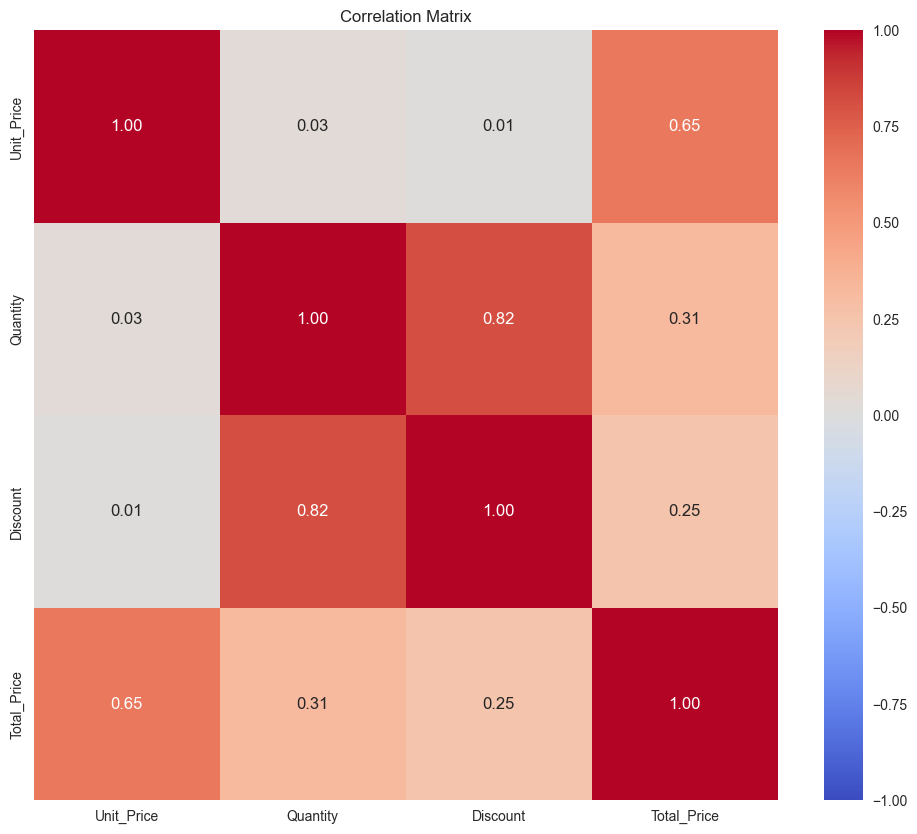

In [12]:
# Visualisasi korelasi antar variabel numerik dengan nilai korelasi ditampilkan
plt.figure(figsize=(12, 10))
correlation_matrix = df_sample[numeric_cols].corr()

sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

**Insights:**
- Semakin tinggi harga per unit, semakin besar total transaksi.
- semakin banyak barang yang dibeli, semakin besar diskon yang diberikan.

**Notes:**
- korelasi tinggi antara Quantity dan Discount, mungkin hanya salah satu yang dipilih dalam model
- Gunakan standardization atau min-max scaling pada Total_Price dan Unit_Price agar nilai dalam skala yang lebih seimbang.

#### **Numerikal - Kategorikal**

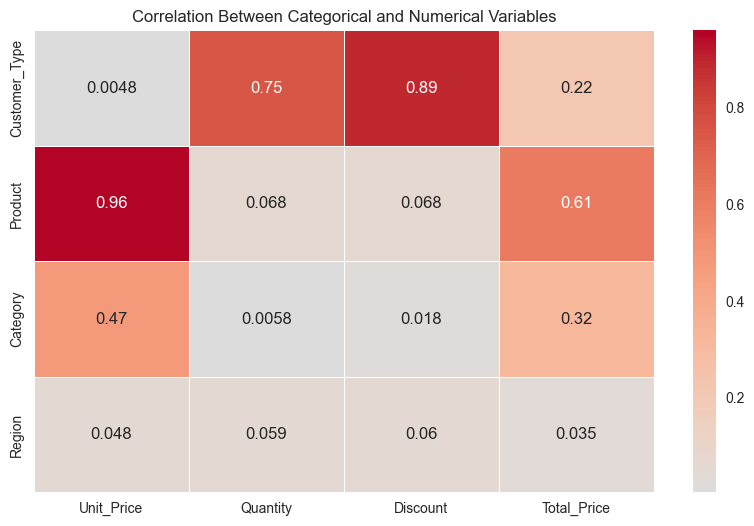

In [13]:
# Daftar kolom numerik dan kategorikal
num_cols = ['Unit_Price', 'Quantity', 'Discount', 'Total_Price']
cat_cols = ['Customer_Type', 'Product', 'Category', 'Region']

# Buat DataFrame untuk menyimpan hasil korelasi
correlation_results = pd.DataFrame(index=cat_cols, columns=num_cols)

# Mean Encoding untuk setiap kategori dan hitung korelasinya
for cat in cat_cols:
    for num in num_cols:
        mean_encoded = df_sample.groupby(cat)[num].mean()  # Mean Encoding
        df_encoded = df_sample[cat].map(mean_encoded)  # Mapping ke dataset utama
        
        correlation = df_encoded.corr(df_sample[num])  # Hitung korelasi Pearson
        correlation_results.loc[cat, num] = correlation

# Konversi ke tipe float untuk visualisasi
correlation_results = correlation_results.astype(float)

# Visualisasi Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_results, annot=True, cmap="coolwarm", center=0, linewidths=0.5)
plt.title("Correlation Between Categorical and Numerical Variables")
plt.show() 


**Insights:**
- B2B cenderung membeli dalam jumlah besar, sedangkan B2C membeli dalam jumlah lebih kecil

**Notes:**
- Customer_Type perlu One-Hot Encoding atau Label Encoding sebelum masuk ke model.
- Jika clustering dilakukan, lebih baik menggunakan kategori produk daripada harga unit langsung.
- Gunakan Mean Encoding pada Product untuk membantu model dalam menangkap hubungan ini.

#### **Kategorikal**

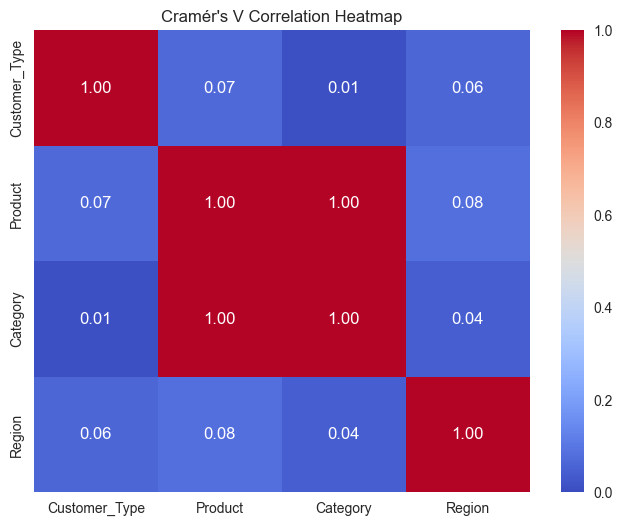

In [14]:
# Fungsi untuk menghitung Cramér's V
def cramers_v(confusion_matrix):
    chi2, p, dof, expected = chi2_contingency(confusion_matrix)
    return np.sqrt(chi2 / (confusion_matrix.sum().sum() * (min(confusion_matrix.shape) - 1)))

# Membuat DataFrame untuk fitur kategori
cat_cols = ['Customer_Type', 'Product', 'Category', 'Region']

# Membuat matrix korelasi Cramér's V antar kolom kategori
cramers_v_matrix = pd.DataFrame(index=cat_cols, columns=cat_cols)

# Menghitung Cramér's V untuk setiap pasangan fitur
for col1 in cat_cols:
    for col2 in cat_cols:
        # Menghitung tabel kontingensi untuk setiap pasangan fitur
        confusion_matrix = pd.crosstab(df_sample[col1], df_sample[col2])
        # Menghitung dan menyimpan Cramér's V
        cramers_v_matrix.loc[col1, col2] = cramers_v(confusion_matrix)

# Visualisasi Cramér's V matrix menggunakan heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cramers_v_matrix.astype(float), annot=True, cmap='coolwarm', fmt='.2f', vmin=0, vmax=1)
plt.title("Cramér's V Correlation Heatmap")
plt.show()

**Insights:**
- category dan product memiliki korelasi 1 sehingga hanya bisa menggunakan salah satu nya saja

# **5. Data Preprocessing**

Pada tahap ini, data preprocessing adalah langkah penting untuk memastikan kualitas data sebelum digunakan dalam model machine learning. Data mentah sering kali mengandung nilai kosong, duplikasi, atau rentang nilai yang tidak konsisten, yang dapat memengaruhi kinerja model. Oleh karena itu, proses ini bertujuan untuk membersihkan dan mempersiapkan data agar analisis berjalan optimal.

Berikut adalah tahapan-tahapan yang bisa dilakukan, tetapi **tidak terbatas** pada:
1. Menghapus atau Menangani Data Kosong (Missing Values)
2. Menghapus Data Duplikat
3. Normalisasi atau Standarisasi Fitur
4. Deteksi dan Penanganan Outlier
5. Encoding Data Kategorikal
6. Binning (Pengelompokan Data)

Cukup sesuaikan dengan karakteristik data yang kamu gunakan yah.

### **1) Missing Value**
Tidak ada Missing Value pada dataset ini

### **2) Data Duplikat**

In [15]:
# 2) Pastikan tidak ada duplikat (tergantung logika data kamu)
#    Misal, kalau 'Order_ID' + 'Product' seharusnya unik:

# Cek duplikat berdasarkan kolom 'Order_ID' dan 'Product'
duplicate_rows = initial_df[initial_df.duplicated(subset=['Order_ID', 'Product'])]
print("Total Duplicate Rows (Order_ID + Product): ", duplicate_rows.shape[0])

# initial_df.drop_duplicates(subset=['Order_ID', 'Product'], inplace=True)

Total Duplicate Rows (Order_ID + Product):  0


#### **3) Deteksi dan Penanganan Outlier**
Berdasarkan distribusi yang telah dianalisis sebelumnya, memang ada beberapa nilai yang terlihat seperti outliers (terutama pada Unit_Price dan Total_Price), namun ini lebih cenderung merupakan pola yang sah dalam dataset, bukan kesalahan sehingga tidak perlu untuk diperbaiki. Berikut adalah pembuktiannya,

**Insights:**
- Outliers menunjukkan harga ekstrem yang ada pada beberapa produk, terutama pada produk alkohol dan beberapa minuman premium. Outliers seperti ini bisa saja mencerminkan adanya harga premium yang tidak dapat dihindari, terutama pada produk-produk yang memiliki karakteristik kemasan atau ukuran spesial.

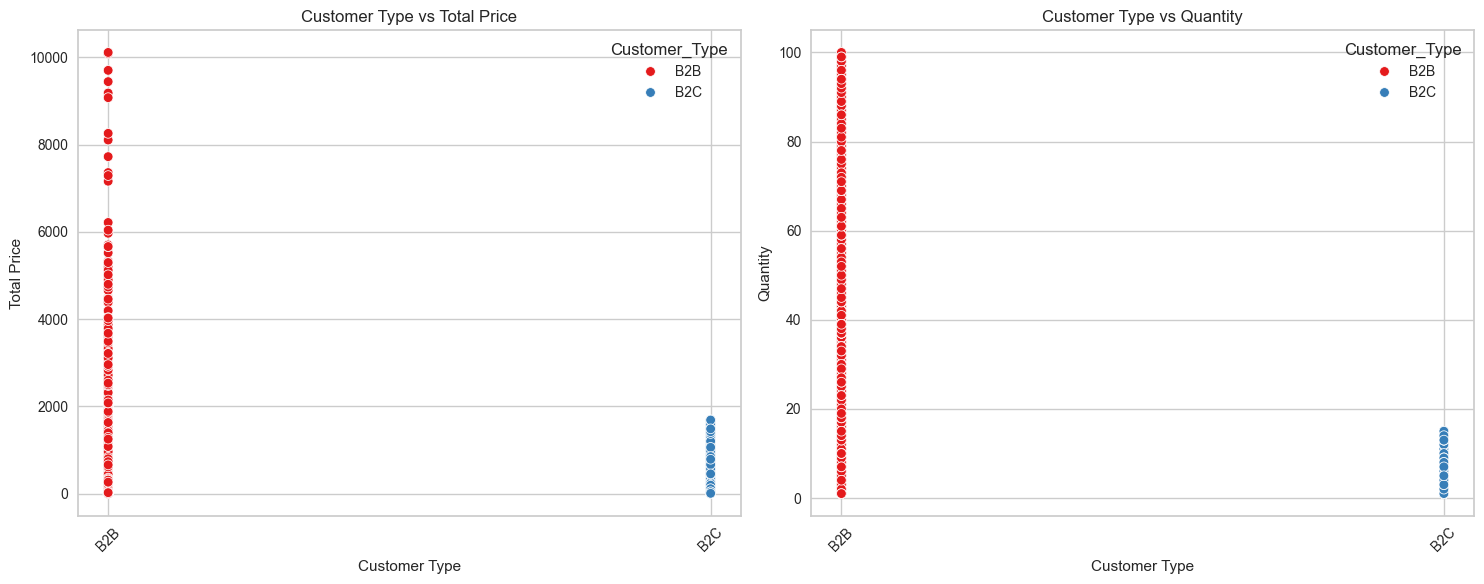

In [16]:
# Membuat subplot untuk 2 scatter plot
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Scatter plot pertama: Customer_Type vs Total_Price
sns.scatterplot(x='Customer_Type', y='Total_Price', data=df_sample, ax=axes[0], hue='Customer_Type', palette='Set1')
axes[0].set_title('Customer Type vs Total Price')
axes[0].set_xlabel('Customer Type')
axes[0].set_ylabel('Total Price')
axes[0].tick_params(axis='x', rotation=45)  # Rotasi label x-axis

# Scatter plot kedua: Customer_Type vs Quantity
sns.scatterplot(x='Customer_Type', y='Quantity', data=df_sample, ax=axes[1], hue='Customer_Type', palette='Set1')
axes[1].set_title('Customer Type vs Quantity')
axes[1].set_xlabel('Customer Type')
axes[1].set_ylabel('Quantity')
axes[1].tick_params(axis='x', rotation=45)  # Rotasi label x-axis

# Menyesuaikan layout
plt.tight_layout()
plt.show()


**Insights:**
- Outliers pada B2B tidak perlu dibuang karena mereka menunjukkan transaksi yang relevan untuk pembeli dengan anggaran besar atau pembelian dalam jumlah besar yang menjadi ciri khas dari pasar B2B.
- Outliers pada B2C juga menunjukkan adanya perilaku pembelian khusus, seperti pembelian dalam jumlah besar yang mungkin perlu ditangani dengan pendekatan berbeda.

### **4) Konversi Tipe Data**

In [17]:
initial_df['Order_Date'] = pd.to_datetime(initial_df['Order_Date'])
initial_df['Order_Date'].sample(5, random_state=0)

1097018   2023-03-11
367205    2023-06-15
8284638   2022-11-19
3385218   2021-12-24
3010030   2022-05-22
Name: Order_Date, dtype: datetime64[ns]

### **5) Preprocessing (***Feature Engineering***)** 

#### **Data Aggregation to Customer Level**

In [18]:
# Tentukan tanggal terakhir dalam dataset (untuk perhitungan Recency)
last_date = initial_df['Order_Date'].max()

# Lakukan agregasi
customer_df = (
    initial_df
    .groupby('Customer_ID')
    .agg({
        'Order_ID': 'nunique',     # jumlah order unik sebagai Frequency
        'Total_Price': 'sum',      # total pembelian sebagai Monetary
        'Quantity': 'sum',         # total quantity (opsional)
        'Discount': 'mean',        # rata-rata diskon (opsional)
        'Order_Date': 'max'        # untuk menghitung Recency
    })
    .reset_index()
)

# Ubah nama kolom agar lebih deskriptif
customer_df.rename(columns={
    'Order_ID': 'frequency',
    'Total_Price': 'monetary',
    'Quantity': 'total_qty',
    'Discount': 'avg_discount',
    'Order_Date': 'last_purchase_date'
}, inplace=True)

# Hitung Recency (selisih hari antara last_date dan last_purchase_date)
customer_df['recency'] = (last_date - customer_df['last_purchase_date']).dt.days

In [19]:
# Contoh menambahkan kolom Customer_Type (B2B / B2C)
#   1) Kita perlu tahu, satu customer bisa B2B dan B2C sekaligus atau tidak?
#      Jika "Customer_Type" per customer selalu konsisten, kita bisa ambil mode/first.
#   2) Kalau satu customer bisa punya banyak order dengan type berbeda, harus didefinisikan logikanya.

# Check apakah satu customer bisa B2B dan B2C sekaligus
customer_order_type = initial_df.groupby('Customer_ID')['Customer_Type'].nunique()
print("Total Customer dengan Customer_Type > 1: ", customer_order_type[customer_order_type > 1].shape[0])

temp_type = (
    initial_df[['Customer_ID', 'Customer_Type']]
    .drop_duplicates(subset=['Customer_ID'])  # Asumsi 1 customer hanya 1 type
)

# Gabungkan type ke customer_df
customer_df = customer_df.merge(temp_type, on='Customer_ID', how='left')

Total Customer dengan Customer_Type > 1:  0


In [20]:
# Average Quantity per Order
customer_df['avg_qty'] = customer_df['total_qty'] / customer_df['frequency']

# Variety of Product Categories purchased
variety_df = (
    initial_df.groupby('Customer_ID')['Category']
    .nunique()
    .reset_index()
    .rename(columns={'Category': 'variety_categories'})
)
customer_df = customer_df.merge(variety_df, on='Customer_ID', how='left')

# Region: Ambil region yang paling sering muncul (mode) per customer
region_df = (
    initial_df.groupby('Customer_ID')['Region']
    .agg(lambda x: x.mode()[0])
    .reset_index()
)
customer_df = customer_df.merge(region_df, on='Customer_ID', how='left')

# ever_discounted: Apakah customer pernah mendapatkan diskon?
customer_df['ever_discounted'] = (customer_df['avg_discount'] > 0).astype(int)

In [21]:
customer_df.sample(5, random_state=0)

,Customer_ID,frequency,monetary,total_qty,avg_discount,last_purchase_date,recency,Customer_Type,avg_qty,variety_categories,Region,ever_discounted
9394,CUS9453,308,47764.49,7271,0.00000,2023-12-27,3,B2C,23.607143,4,Sachsen,0
898,CUS1806,315,274195.99,48537,0.08238,2023-12-24,6,B2B,154.085714,4,Hamburg,1
2398,CUS3156,302,44346.41,6956,0.00000,2023-12-29,1,B2C,23.033113,4,Brandenburg,0
5906,CUS6313,274,42487.64,6383,0.00000,2023-12-23,7,B2C,23.295620,4,Hamburg,0
2343,CUS3106,297,40776.32,7097,0.00000,2023-12-30,0,B2C,23.895623,4,Hessen,0


#### **Data Transformation**

In [22]:
# log transform
customer_df['log_monetary']   = np.log1p(customer_df['monetary'])
customer_df['log_frequency']  = np.log1p(customer_df['frequency'])
customer_df['log_total_qty']  = np.log1p(customer_df['total_qty'])
customer_df['log_avg_qty']    = np.log1p(customer_df['avg_qty'])

In [23]:
customer_df.sample(5, random_state=0)

,Customer_ID,frequency,monetary,total_qty,avg_discount,last_purchase_date,recency,Customer_Type,avg_qty,variety_categories,Region,ever_discounted,log_monetary,log_frequency,log_total_qty,log_avg_qty
9394,CUS9453,308,47764.49,7271,0.00000,2023-12-27,3,B2C,23.607143,4,Sachsen,0,10.774059,5.733341,8.891787,3.203037
898,CUS1806,315,274195.99,48537,0.08238,2023-12-24,6,B2B,154.085714,4,Hamburg,1,12.521602,5.755742,10.790102,5.043978
2398,CUS3156,302,44346.41,6956,0.00000,2023-12-29,1,B2C,23.033113,4,Brandenburg,0,10.699810,5.713733,8.847504,3.179433
5906,CUS6313,274,42487.64,6383,0.00000,2023-12-23,7,B2C,23.295620,4,Hamburg,0,10.656992,5.616771,8.761550,3.190296
2343,CUS3106,297,40776.32,7097,0.00000,2023-12-30,0,B2C,23.895623,4,Hessen,0,10.615881,5.697093,8.867568,3.214692


In [24]:
# EDA Table for Customer DataFrame
eda_table_customer = render_eda_table_as_html(create_eda_table(customer_df))
display(HTML(eda_table_customer))

Column,Data Type,Missing Values,Unique Values,Sample Value
Customer_ID,object,0,10000,CUS1
frequency,int64,0,116,305
monetary,float64,0,9990,38904.13
total_qty,int64,0,4989,7508
avg_discount,float64,0,3124,0.0
last_purchase_date,datetime64[ns],0,32,2023-12-29 00:00:00
recency,int64,0,32,1
Customer_Type,object,0,2,B2C
avg_qty,float64,0,9476,24.616393
variety_categories,int64,0,1,4


#### **Encoding Kategorikal**

In [25]:
le = LabelEncoder()
# label_columns = ['Customer_Type', 'Region']

# label_encoder_dict = {}

customer_df['Customer_Type_encoded'] = le.fit_transform(customer_df['Customer_Type'])
# label_encoder_dict['Customer_Type'] = le

customer_df['Region_encoded'] = le.fit_transform(customer_df['Region'])
# label_encoder_dict['Region'] = le

In [26]:
customer_df.sample(5, random_state=0)

,Customer_ID,frequency,monetary,total_qty,avg_discount,last_purchase_date,recency,Customer_Type,avg_qty,variety_categories,Region,ever_discounted,log_monetary,log_frequency,log_total_qty,log_avg_qty,Customer_Type_encoded,Region_encoded
9394,CUS9453,308,47764.49,7271,0.00000,2023-12-27,3,B2C,23.607143,4,Sachsen,0,10.774059,5.733341,8.891787,3.203037,1,12
898,CUS1806,315,274195.99,48537,0.08238,2023-12-24,6,B2B,154.085714,4,Hamburg,1,12.521602,5.755742,10.790102,5.043978,0,5
2398,CUS3156,302,44346.41,6956,0.00000,2023-12-29,1,B2C,23.033113,4,Brandenburg,0,10.699810,5.713733,8.847504,3.179433,1,3
5906,CUS6313,274,42487.64,6383,0.00000,2023-12-23,7,B2C,23.295620,4,Hamburg,0,10.656992,5.616771,8.761550,3.190296,1,5
2343,CUS3106,297,40776.32,7097,0.00000,2023-12-30,0,B2C,23.895623,4,Hessen,0,10.615881,5.697093,8.867568,3.214692,1,6


In [30]:
# Tentukan kolom yang ingin dihapus (misalnya, kolom 'Cluster' dan 'Customer_Type')
columns_to_drop = ['Customer_ID', 'last_purchase_date', 'Customer_Type', 'Customer_Type_encoded', 'Region']  # kolom ini harus dihapus karena mengandung label dan merupakan nilai kategorikal

# Copy customer_df ke X tanpa kolom yang ditentukan
X = customer_df.drop(columns=columns_to_drop).copy()

# Tampilkan X untuk memastikan kolom sudah dihapus
X.head()


,frequency,monetary,total_qty,avg_discount,recency,avg_qty,variety_categories,ever_discounted,log_monetary,log_frequency,log_total_qty,log_avg_qty,Region_encoded
0,305,38904.13,7508,0.000000,1,24.616393,4,0,10.568881,5.723585,8.923858,3.243233,7
1,296,40288.83,6910,0.000000,2,23.344595,4,0,10.603854,5.693732,8.840870,3.192310,11
2,287,36039.74,7163,0.000000,3,24.958188,4,0,10.492405,5.662960,8.876824,3.256487,1
3,289,271186.90,44318,0.082747,1,153.349481,4,1,12.510567,5.669881,10.699169,5.039219,15
4,299,253436.72,46184,0.083800,7,154.461538,4,1,12.442873,5.703782,10.740410,5.046398,12


#### **Data Scaling**

In [31]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#### **Dimensionality Reduction**

In [32]:
# Menggunakan PCA untuk menentukan jumlah komponen yang menjelaskan setidaknya 90% variansi
pca_temp = PCA()
pca_temp.fit(X_scaled)
cumulative_variance = np.cumsum(pca_temp.explained_variance_ratio_)
print("Cumulative Explained Variance Ratio:")
cumulative_variance

Cumulative Explained Variance Ratio:


array([0.66306538, 0.83099666, 0.91588955, 0.99681607, 0.99896468,
       0.99956359, 0.99977386, 0.9998755 , 0.99994213, 0.99998901,
       1.        , 1.        , 1.        ])

In [33]:
# Tentukan n_components minimal yang mencapai threshold 90%
n_components = np.argmax(cumulative_variance >= 0.80) + 1
print("Number of components to explain at least 80% variance:", n_components)

Number of components to explain at least 80% variance: 2


In [34]:
# Terapkan PCA dengan n_components yang sudah ditentukan
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# **6. Pembangunan Model Clustering**

## **a. Pembangunan Model Clustering**

### **KMeans**

c:\Users\Jihan Aurelia\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Jihan Aurelia\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Jihan Aurelia\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Jihan Aurelia\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 

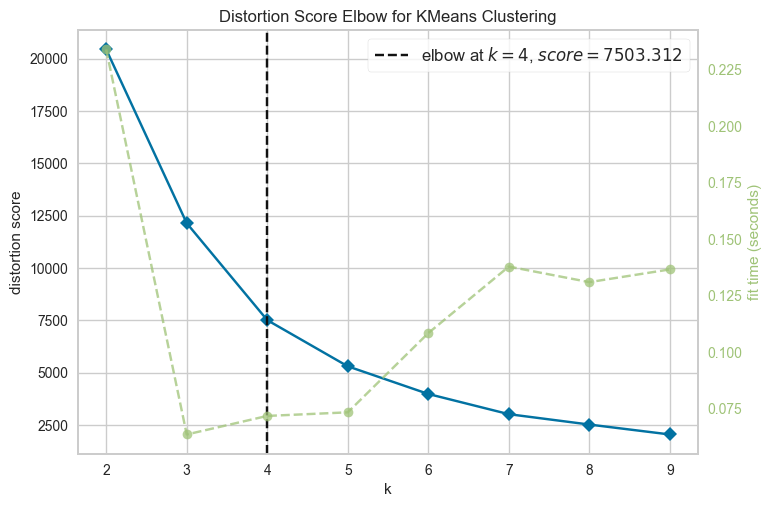

In [35]:
# Tentukan jumlah cluster optimal (contoh menggunakan Elbow Method)
model = KMeans(random_state=42)
visualizer = KElbowVisualizer(model, k=(2,10))
visualizer.fit(X_pca)
visualizer.show()
n_clusters = visualizer.elbow_value_

In [36]:
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(X_pca)

# Simpan label cluster ke data customer
customer_df['cluster'] = kmeans.labels_

# Evaluasi hasil clustering dengan Silhouette Score
labels = kmeans.labels_
sil_score = silhouette_score(X_pca, labels)
print("Silhouette Score:", sil_score)

c:\Users\Jihan Aurelia\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score: 0.5408624412040467


c:\Users\Jihan Aurelia\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Jihan Aurelia\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Jihan Aurelia\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


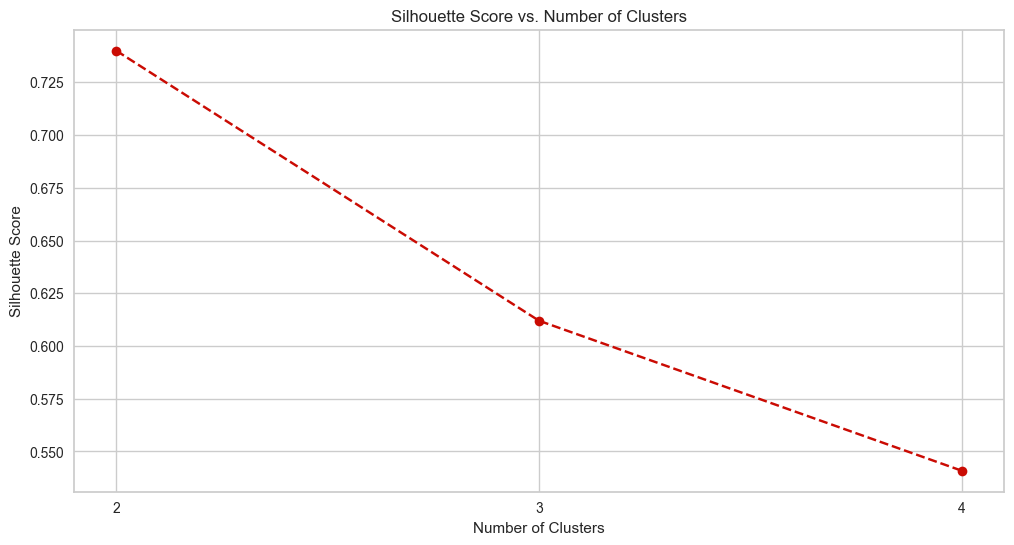

In [37]:
# iterate n_clusters to get the best silhouette score
silhouette_scores = []

for n_cluster in range(2, n_clusters+1):
    kmeans = KMeans(n_clusters=n_cluster, random_state=42)
    kmeans.fit(X_pca)
    labels = kmeans.labels_
    silhouette_scores.append(silhouette_score(X_pca, labels))

# Plotting Silhouette Score
plt.figure(figsize=(12, 6))
plt.plot(range(2, n_clusters+1), silhouette_scores, marker='o', linestyle='--', color='r')
plt.title('Silhouette Score vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.xticks(range(2, n_clusters+1))
plt.grid(True)
plt.show()

## **b. Evaluasi Model Clustering**

In [39]:
#Menentukan jumlah cluster terbaik (misalnya, dari hasil Elbow & Silhouette Score)
optimal_k = silhouette_scores.index(max(silhouette_scores)) + 2  # +2 karena range dimulai dari 2

#Membangun Model K-Means
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(X_pca)

# silhouette score
final_labels = kmeans.labels_
score_all = silhouette_score(X_pca, final_labels)
print("Jumlah Cluster Terbaik:", optimal_k)
print("Silhouette Score:", score_all)

c:\Users\Jihan Aurelia\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Jumlah Cluster Terbaik: 2
Silhouette Score: 0.7399961484466182


## **c. Feature Selection (Opsional)**

In [157]:
features_for_clustering = [
    # 'recency',
    'variety_categories',

    # 'avg_discount',
    'ever_discounted',

    'log_frequency',
    'log_monetary',
    'log_total_qty',
    'log_avg_qty',

    # 'monetary',
    # 'frequency',
    # 'total_qty',
    # 'avg_qty',
]

In [158]:
X = customer_df[features_for_clustering].copy()

In [159]:
X_scaled = scaler.fit_transform(X)

# Menggunakan PCA untuk menentukan jumlah komponen yang menjelaskan setidaknya 90% variansi
pca_temp = PCA()
pca_temp.fit(X_scaled)

# Terapkan PCA dengan n_components yang sudah ditentukan
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

#Membangun Model K-Means
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(X_pca)

# silhouette score
final_labels = kmeans.labels_
score_fs = silhouette_score(X_pca, final_labels)
print("Jumlah Cluster Terbaik:", optimal_k)
print("Silhouette Score:", score_fs)

c:\Users\Jihan Aurelia\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Jumlah Cluster Terbaik: 2
Silhouette Score: 0.7411557343045627


In [160]:
print("Perbandingan Silhouete Score tanpa feature selection (score_all) dan dengan feature selection (score_fs):")
print(f"score_all : {score_all}")
print(f"score_fs : {score_fs}")

Perbandingan Silhouete Score tanpa feature selection (score_all) dan dengan feature selection (score_fs):
score_all : 0.7399961484466182
score_fs : 0.7411557343045627


- score_all menerapkan seluruh fitur pada dataset
- score_fs hanya menerapkan fitur yang menghasilkan silhouete score terbaik

Berdasarkan perbandingan hasil, terlihat bahwa nilai meningkat dengan diterapkannya feature selection.

## **d. Visualisasi Hasil Clustering**

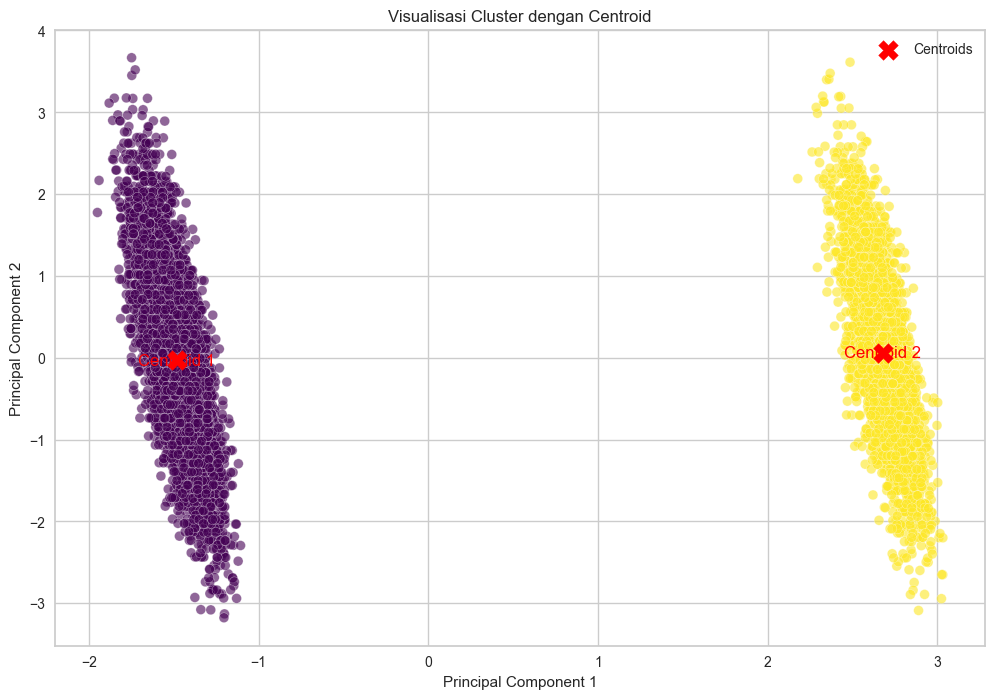

Nilai Centroids:
Centroid 1: PC1 = -1.48, PC2 = -0.03
Centroid 2: PC1 = 2.68, PC2 = 0.06


In [166]:
# Menentukan posisi centroid
centroids = kmeans.cluster_centers_

# Visualisasi cluster
plt.figure(figsize=(12, 8))

# Plot data: Kita akan gunakan X_pca untuk dimensi 2 utama dari PCA, dan gunakan labels untuk warna
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=final_labels, cmap='viridis', s=50, alpha=0.6, edgecolors='w', marker='o')

# Plot centroid: Menambahkan centroids ke plot
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=200, marker='X', label='Centroids')

# Menambahkan label centroid pada plot
for i, centroid in enumerate(centroids):
    plt.text(centroid[0], centroid[1], f'Centroid {i+1}', color='red', fontsize=12, ha='center', va='center')

# Menambahkan judul dan label sumbu
plt.title('Visualisasi Cluster dengan Centroid')
plt.xlabel('Principal Component 1')  # X-axis
plt.ylabel('Principal Component 2')  # Y-axis
plt.legend()

# Menampilkan plot
plt.show()

# Menampilkan nilai centroid
print("Nilai Centroids:")
for i, centroid in enumerate(centroids):
    print(f"Centroid {i+1}: PC1 = {centroid[0]:.2f}, PC2 = {centroid[1]:.2f}")

## **e. Analisis dan Interpretasi Hasil Cluster**

### **Interpretasi Target**

In [167]:
customer_df['cluster'] = final_labels

# Display the DataFrame to confirm the new column has been added
customer_df.head()

,Customer_ID,frequency,monetary,total_qty,avg_discount,last_purchase_date,recency,Customer_Type,avg_qty,variety_categories,Region,ever_discounted,log_monetary,log_frequency,log_total_qty,log_avg_qty,Customer_Type_encoded,Region_encoded,cluster
0,CUS1,305,38904.13,7508,0.000000,2023-12-29,1,B2C,24.616393,4,Mecklenburg-Vorpommern,0,10.568881,5.723585,8.923858,3.243233,1,7,0
1,CUS10,296,40288.83,6910,0.000000,2023-12-28,2,B2C,23.344595,4,Saarland,0,10.603854,5.693732,8.840870,3.192310,1,11,0
2,CUS100,287,36039.74,7163,0.000000,2023-12-27,3,B2C,24.958188,4,Bayern,0,10.492405,5.662960,8.876824,3.256487,1,1,0
3,CUS1000,289,271186.90,44318,0.082747,2023-12-29,1,B2B,153.349481,4,Thüringen,1,12.510567,5.669881,10.699169,5.039219,0,15,1
4,CUS10000,299,253436.72,46184,0.083800,2023-12-23,7,B2B,154.461538,4,Sachsen,1,12.442873,5.703782,10.740410,5.046398,0,12,1


In [168]:
# Kolom yang sesuai dengan dataset clustering
columns_to_keep = features_for_clustering + ['cluster']

# Filter the DataFrame to only include the selected columns
customer_df_filtered = customer_df[columns_to_keep]

# Display the filtered DataFrame
customer_df_filtered.head()

,variety_categories,ever_discounted,log_frequency,log_monetary,log_total_qty,log_avg_qty,cluster
0,4,0,5.723585,10.568881,8.923858,3.243233,0
1,4,0,5.693732,10.603854,8.840870,3.192310,0
2,4,0,5.662960,10.492405,8.876824,3.256487,0
3,4,1,5.669881,12.510567,10.699169,5.039219,1
4,4,1,5.703782,12.442873,10.740410,5.046398,1


#### **nilai mean dari kolom numerikal**

In [169]:
# Perform aggregation for each cluster: min, max, and mean
numeric_aggregates = customer_df_filtered.groupby('cluster').agg(['min', 'max', 'mean'])

numeric_aggregates_transposed = numeric_aggregates.transpose()
numeric_aggregates_transposed

cluster                          0          1
variety_categories min    4.000000   4.000000
                   max    4.000000   4.000000
                   mean   4.000000   4.000000
ever_discounted    min    0.000000   1.000000
                   max    0.000000   1.000000
                   mean   0.000000   1.000000
log_frequency      min    5.493061   5.501258
                   max    5.886104   5.886104
                   mean   5.705512   5.705374
log_monetary       min   10.131745  11.946943
                   max   11.118785  12.815139
                   mean  10.655198  12.434350
log_total_qty      min    8.618485  10.474269
                   max    9.132703  10.931677
                   mean   8.880092  10.721830
log_avg_qty        min    3.103265   4.884949
                   max    3.327787   5.144127
                   mean   3.218632   5.026361

# Analisis Karakteristik Cluster dari Model KMeans

Berikut adalah analisis karakteristik untuk setiap cluster yang dihasilkan dari model KMeans.

## **Cluster 1: Frequent Shoppers**
- Klaster ini mencakup pelanggan dengan pendapatan tahunan yang menengah dan tingkat pengeluaran yang cukup tinggi. Pelanggan di klaster ini membeli produk dalam 4 kategori produk dengan pengeluaran moderat.
- Recency (rata-rata 3.1): Menunjukkan bahwa pelanggan di klaster ini cenderung baru-baru ini melakukan pembelian, tetapi dengan rentang waktu yang cukup variatif.
- Variety Categories (nilai rata-rata 4): Mereka cenderung membeli dalam variasi produk yang lebih sedikit.
- Avg Discount (nilai rata-rata 0%): Tidak banyak diskon yang diterima oleh pelanggan di klaster ini, mungkin mereka lebih sering membeli produk tanpa diskon besar.
- Monetary (rata-rata 42,731 K$): Pembelian mereka cukup besar, tetapi tidak setinggi klaster B2B.
- Frequency (rata-rata 300 pembelian): Klaster ini melakukan pembelian dengan frekuensi yang lebih sering.
- Total Quantity (rata-rata 7202 unit): Klaster ini membeli produk dalam jumlah sedang.

***Inisights:***
- Pelanggan di klaster ini lebih cenderung melakukan pembelian dalam jumlah kecil dengan frekuensi yang lebih sering, namun pengeluaran per transaksi relatif sedang. Hal ini menunjukkan bahwa mereka lebih mengutamakan pembelian dalam jumlah sedikit tetapi lebih sering.
- Untuk meningkatkan penjualan di klaster ini, Anda bisa menggunakan penawaran berbasis diskon atau loyalty programs untuk meningkatkan frekuensi pembelian.
- Avg Quantity (rata-rata 24 unit): Setiap pembelian di klaster ini cenderung membeli dalam jumlah unit yang sedang.

## **Cluster 2: Bulk Buyers**
- Klaster ini mencerminkan pelanggan dengan pendapatan tahunan yang sangat tinggi dan pengeluaran yang sangat besar. Pelanggan di klaster ini lebih berfokus pada pembelian dalam jumlah besar, yang menunjukkan bahwa mereka mungkin berhubungan dengan pembelian grosir atau perusahaan.
- Recency (rata-rata 31.92): Meskipun mereka memiliki pengeluaran tinggi, recency menunjukkan bahwa pembelian mereka terjadi dengan rentang waktu yang lebih panjang dibandingkan klaster B2C.
- Variety Categories (nilai rata-rata 4): Mereka membeli produk dalam jumlah kategori yang sangat terbatas.
- Avg Discount (nilai rata-rata 8%): Klaster ini lebih cenderung mendapatkan diskon lebih besar, mungkin karena pembelian dalam volume besar.
- Monetary (rata-rata 253,050 K$): Pembelian mereka sangat besar dibandingkan klaster lainnya.
- Frequency (rata-rata 299 pembelian): Mereka melakukan pembelian dengan frekuensi yang lebih rendah daripada klaster B2C, tetapi setiap transaksi bernilai tinggi.
- Total Quantity (rata-rata 454373 unit): Pembelian dalam klaster ini lebih besar, menunjukkan pembelian produk dalam jumlah besar.
- Avg Quantity (rata-rata 151 unit): Pembelian dalam klaster ini melibatkan lebih banyak produk per transaksi.

***Insights:***
- Pelanggan di klaster ini melakukan pembelian dalam jumlah besar dan mengeluarkan uang lebih banyak per transaksi, dengan diskon yang lebih tinggi. Mereka berfokus pada pembelian grosir atau volume besar.
- Untuk klaster ini, strategi penjualan yang lebih efektif mungkin melibatkan penawaran grosir dengan harga lebih kompetitif dan diskon berbasis volume.

# **7. Mengeksport Data**

Simpan hasilnya ke dalam file CSV.

In [171]:
customer_df_filtered.to_csv('Dataset_inisiasi.csv', index=False)